#  Прогнозирование спроса на такси 

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Импортируем-необходимые-библиотеки" data-toc-modified-id="Импортируем-необходимые-библиотеки-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Импортируем необходимые библиотеки</a></span></li><li><span><a href="#Используемые-функции" data-toc-modified-id="Используемые-функции-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>Используемые функции</a></span></li></ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Выполним-ресемплирование-по-одному-часу" data-toc-modified-id="Выполним-ресемплирование-по-одному-часу-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Выполним ресемплирование по одному часу</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

### Импортируем необходимые библиотеки

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns

# задаём значение констант
TEST_SIZE = 0.1
RANDOM_STATE = 42 

# игнорируем предупреждения
import warnings
warnings.simplefilter("ignore")

### Используемые функции

In [2]:
def plot_graph(x, y, title, xlabel='Дата и время', ylabel='Количество заказов', xticks=None):
    sns.set_style("darkgrid")
    sns.set_palette("Set1")
    plt.figure(figsize=(15, 5))
    sns.lineplot(x=x, y=y)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if xticks is not None:
        plt.xticks(ticks=xticks)
    plt.grid(True)
    plt.show()

## Подготовка

### Загрузка данных

Считаем CSV-файлы в датафреймы

In [3]:
# Чтение файла и создание датафрейма
local_file_path = '/datasets/taxi.csv'
online_file_path = 'https://xxx/datasets/taxi.csv'

try:
    if os.path.exists(local_file_path):
        df = pd.read_csv(local_file_path, index_col=[0], parse_dates=[0])
        print(f"Данные загружены из локальной директории") 
    else:
        df = pd.read_csv(online_file_path, index_col=[0], parse_dates=[0])
        print(f"Данные загружены из сети")
except Exception as e:
    print(f"Произошла ошибка при чтении файла: {e}")

Данные загружены из локальной директории


In [4]:
# Проверка загрузки данных
print(f'Начальная дата: {df.index.min()}')
print(f'Конечная дата: {df.index.max()}')
print('*'*80)
print('\nОбщая информация о датафрейме:') 
print(df.info())
print('*'*80)
print('\nОписательная статистика:')
display(df.describe().T)
print('*'*80)
print('Количество пропусков:\n', df.isna().sum())
print('*'*80)
print('\nПроверка на монотонность:')
print(df.index.is_monotonic_increasing)
print('*'*80)
print('\nПример данных:')
display(df.head())

Начальная дата: 2018-03-01 00:00:00
Конечная дата: 2018-08-31 23:50:00
********************************************************************************

Общая информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None
********************************************************************************

Описательная статистика:


,count,mean,std,min,25%,50%,75%,max
num_orders,26496.0,14.070463,9.21133,0.0,8.0,13.0,19.0,119.0


********************************************************************************
Количество пропусков:
 num_orders    0
dtype: int64
********************************************************************************

Проверка на монотонность:
True
********************************************************************************

Пример данных:


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


### Выполним ресемплирование по одному часу

In [5]:
df = df.resample('1H').sum()

**Вывод:**
* датасет taxi.csv содержит 26496 записей
* период с 1 марта 2018 года по 31 августа 2018 года
* пропуски в данных отсутствуют
* данные расположены в хронологическом порядке

## Анализ

Построим график количества заказов по часам

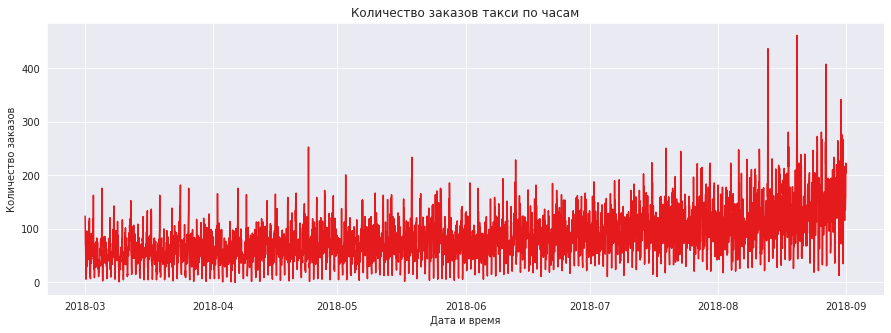

In [6]:
plot_graph(df.index, 
           df['num_orders'], 
           'Количество заказов такси по часам')

Декомпозируем данные

In [7]:
decomposed_taxi = seasonal_decompose(df)

Построим график трендов

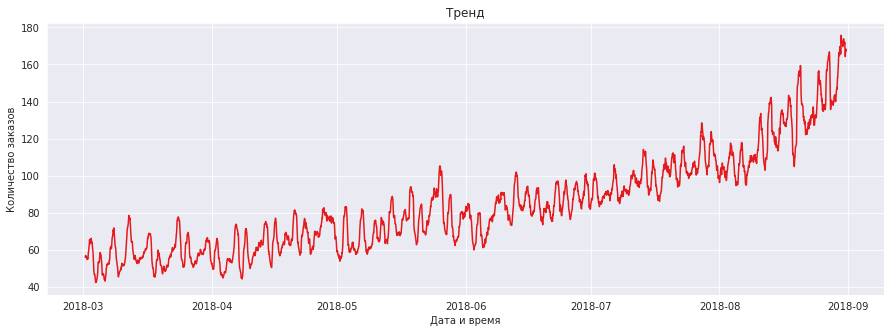

In [8]:
plot_graph(decomposed_taxi.trend.index,
           decomposed_taxi.trend, 
           'Тренд')

Построим графики сезонности

за весь период:

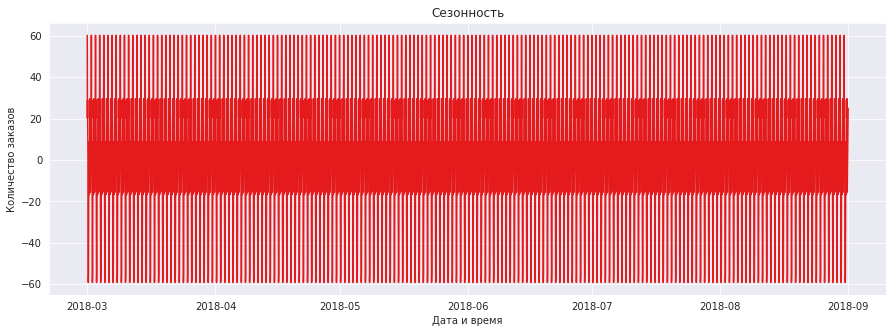

In [9]:
plot_graph(decomposed_taxi.seasonal.index, 
           decomposed_taxi.seasonal, 
           'Сезонность')

за неделю:

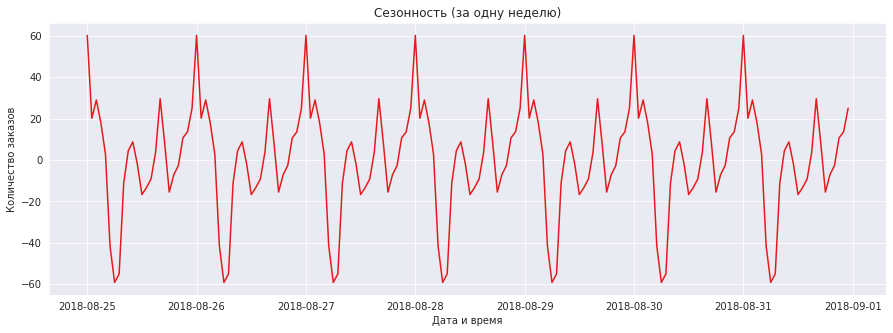

In [10]:
plot_graph(decomposed_taxi.seasonal['2018-08-25':'2018-08-31'].index,
           decomposed_taxi.seasonal['2018-08-25':'2018-08-31'],
           'Сезонность (за одну неделю)')

за три дня:

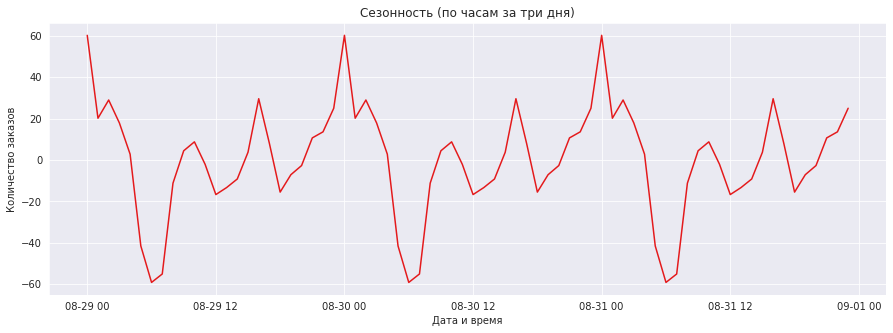

In [11]:
plot_graph(decomposed_taxi.seasonal['2018-08-29':'2018-08-31'].index, 
           decomposed_taxi.seasonal['2018-08-29':'2018-08-31'], 
           'Сезонность (по часам за три дня)')

Напишем функцию для создания новых признаков

In [12]:
def create_features(df, max_lag, rolling_mean_size):
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df[f'lag_{lag}'] = df['num_orders'].shift(lag)
    
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    df = df.dropna()
    return df

Создадим новые признаки на основе временных рядов

In [13]:
df_n = create_features(df, max_lag=24, rolling_mean_size=24)

Вычислим среднее количество заказов по часам в течение дня за весь период

In [14]:
average_orders_per_hour = df_n.groupby('hour')['num_orders'].mean()

Построим график среднего количества заказов такси по часам в течение дня за весь период

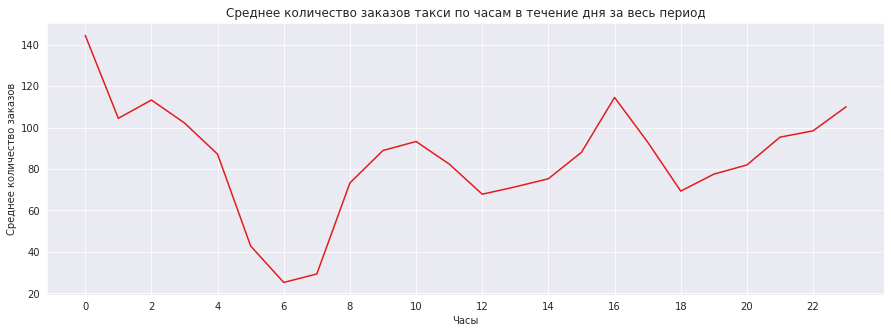

In [15]:
plot_graph(average_orders_per_hour.index, average_orders_per_hour.values, 
           'Среднее количество заказов такси по часам в течение дня за весь период',
           xlabel='Часы', ylabel='Среднее количество заказов', xticks=np.arange(0, 24, 2))

**Вывод:**

по графикам наблюдается:
* с конца апреля начинается рост заказа такси в аэропорт, возможно, это связано с началом сезона отпусков
* минимальное количество заказов такси около 6 утра 
* максимальное количество заказов такси около полуночи

## Обучение

Обучим модели линейной регрессии и случайного леса

Зададим целевую переменную и признаки

In [16]:
X = df_n.drop('num_orders', axis=1)
y = df_n['num_orders']

Разделим данные на обучающую и тестовую выборки, размером 10% от исходных данных

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, shuffle=False)

Масштабируем признаки

In [18]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Обучим модель линейной регрессии с кросс-валидацией

In [19]:
lr = LinearRegression()
tscv = TimeSeriesSplit(n_splits=4)
cv_scores_lr = cross_val_score(lr, X_train_scaled, y_train, cv=tscv, scoring='neg_mean_squared_error')
rmse_cv_lr = np.sqrt(-cv_scores_lr).mean()
print(f'RMSE для линейной регрессии на кросс-валидации: {rmse_cv_lr:.2f}')

RMSE для линейной регрессии на кросс-валидации: 27.31


Обучим модель случайного леса с кросс-валидацией

In [20]:
rf = RandomForestRegressor(random_state=RANDOM_STATE)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30]
}
grid_search = GridSearchCV(rf, param_grid, cv=tscv, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)
best_rf = grid_search.best_estimator_
cv_scores_rf = cross_val_score(best_rf, X_train_scaled, y_train, cv=tscv, scoring='neg_mean_squared_error')
rmse_cv_rf = np.sqrt(-cv_scores_rf).mean()
print(f'RMSE для случайного леса на кросс-валидации: {rmse_cv_rf:.2f}')

RMSE для случайного леса на кросс-валидации: 25.88


Модель случайного леса показала лучший показатель метрики RMSE, проверим её на тестовой выборке

## Тестирование

Проверим данные на тестовой выборке

In [21]:
y_test_pred = best_rf.predict(X_test_scaled)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
print(f'RMSE на тестовой выборке: {rmse_test:.2f}')

RMSE на тестовой выборке: 42.91


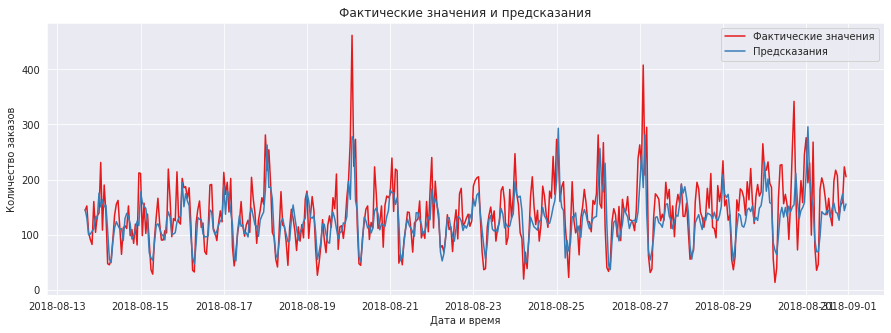

In [22]:
plt.figure(figsize=(15, 5))
sns.lineplot(x=X_test.index, y=y_test, label='Фактические значения')
sns.lineplot(x=X_test.index, y=y_test_pred, label='Предсказания')
plt.title('Фактические значения и предсказания')
plt.xlabel('Дата и время')
plt.ylabel('Количество заказов')
plt.legend()
plt.grid(True)
plt.show()

**Выводы**

In [23]:
# Выводы
if rmse_test <= 48:
    print("Модель соответствует заданным требованиям.")
else:
    print("Модель не соответствует заданным требованиям. Нужно попробовать другие гиперпараметры или модели.")

Модель соответствует заданным требованиям.


**Цель**

Целью данной работы было построить модель для предсказания количества заказов такси на следующий час для компании «Чётенькое такси». Требовалось, чтобы значение метрики RMSE (корень из средней квадратичной ошибки) на тестовой выборке было не больше 48.

**Этапы работы**

1. Подготовка данных:

 * Данные были загружены из файла taxi.csv, проверены на наличие пропусков и монотонность.
 * Данные были ресемплированы по одному часу для создания временного ряда.


2. Анализ данных:

 * Проведен визуальный анализ временного ряда. Построены графики общего количества заказов, тренда и сезонности (за весь период, за неделю, за три дня).
 * Анализ графиков показал, что:
    * С конца апреля начинается рост количества заказов, что может быть связано с началом сезона отпусков.
    * Минимальное количество заказов такси наблюдается около 6 утра.
    * Максимальное количество заказов такси приходится на полночь.


3. Обучение моделей:

 * Были созданы новые признаки на основе временных рядов: час, день недели, лаги и скользящее среднее.
 * Данные были разделены на обучающую и тестовую выборки в соотношении 90% к 10%.
 * Признаки были масштабированы.
 * Обучены две модели: линейной регрессии и случайного леса.
 * Проведена кросс-валидация моделей.
 * Показатели RMSE на кросс-валидации:
    * Линейная регрессия: 27.31
    * Случайный лес: 25.88


4. Тестирование:

 * Проведено тестирование модели случайного леса на тестовой выборке.
 * Показатель RMSE на тестовой выборке составил 42.91, что соответствует заданным требованиям.

**Выводы**

Модель случайного леса показала хороший результат на тестовой выборке, достигнув значения RMSE 42.91, что значительно ниже порогового значения 48. Это означает, что модель успешно предсказывает количество заказов такси на следующий час и может быть использована для привлечения водителей в периоды пиковой нагрузки.